# **TP2 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 1 - Sistema de Tráfego**
Um sistema de tráfego é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e os arcos denotam vias de comunicação só com um sentido. 

> O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$. 

1. Gerar aleatoriamente um tal grafo com $N=32$ nodos. Cada nodo tem um número aleatório de descendentes no intervalo $1..3$ cujos destinos são distintos entre si do nodo origem.
2. Pretende-se fazer manutenção interrompendo determinadas vias. Determinar **o maior número de vias** que é possível remover mantendo o grafo ligado.

In [1]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

## **Funções para gerar aleatoriamente um digrafo ligado**

Primeiramente, vamos começar declarando duas variáveis globais:

`NUM_NODES` é o número de nodos do digrafo;

`MAX_OUT_DEGREE` é o número máximo de descendentes de cada nodo.

In [2]:
NUM_NODES = 32 
MAX_OUT_DEGREE = 3 

### Método 1
Esta estratégia consiste em, basicamente, manter sempre o grafo orientado (ou digrafo) $G$ ligado à medida que se vão adicionando arestas.

Em primeiro lugar, inserimos todos os nodos $n_1, n_2, ..., n_j$ em $G$. De seguida, selecionamos de forma aleatória dois nodos, aos quais chamaremos $s$ e $d$, e adicionamos as arestas $(s, d)$ e $(d, s)$ a $G$. Agora, vamos ligar cada um dos nodos restantes de $G$ de uma forma aleatória, mas mantendo sempre $G$ ligado.

Portanto, selecionamos um nodo $n$ cujo grau de saída é igual a $0$ e um nodo $s$ que já se encontra na parte de $G$ que está ligada. Aqui podemos encontrar dois casos:

1. O grau de saída de $s$ é igual a `MAX_OUT_DEGREE`. Então, selecionamos outro nodo $d$ (que seja sucessor de $s$), removemos a aresta $(s, d)$ e colocamos as arestas $(s, n)$ e $(n, d)$.

2. O grau de saída de $s$ é menor que `MAX_OUT_DEGREE`. Então, escolhe-se à sorte entre três opções: selecionar um nodo $d$ da parte ligada de $G$ e colocar as arestas $(s, n)$ e $(n, d)$ ou colocar as arestas $(s, n)$ e $(n, s)$ ou realizar o mesmo processo realizado para o caso (1).

Por fim, selecionamos cada nodo cujo grau de saída ainda é menor que `MAX_OUT_DEGREE` e colocamos um número $$0 \leq n \leq MAX\_OUT\_DEGREE - G.out\_degree(nodo)$$ de arestas aleatórias, partindo deste nodo.

In [3]:
def graph_generator():
    G = nx.DiGraph()

    nodes = [n for n in range(1,NUM_NODES+1)]
    choosen = []
    G.add_nodes_from(nodes)
    random.shuffle(nodes)
    
    s = random.choice(nodes)
    nodes.remove(s)
    choosen.append(s)
    d = random.choice(nodes)
    nodes.remove(d)
    choosen.append(d)
    
    G.add_edge(s,d)
    G.add_edge(d,s)
    
    while nodes:
        to_add = random.choice(nodes)
        nodes.remove(to_add)
        s = random.choice(choosen)
        option = random.choice([0,1,2])
        if G.out_degree(s) == MAX_OUT_DEGREE or option == 0:
            d = random.choice(list(G.successors(s)))
            G.remove_edge(s,d)
            G.add_edge(s,to_add)
            G.add_edge(to_add,d)
        elif option == 1:
            d = random.choice(choosen)
            G.add_edge(s,to_add)
            G.add_edge(to_add,d)
        else:
            G.add_edge(s,to_add)
            G.add_edge(to_add,s)
            
        choosen.append(to_add)
    
    nodes = [n for n in G.nodes() if G.out_degree(n)<MAX_OUT_DEGREE]
    while nodes:
        s = nodes.pop()
        r = random.randint(0,MAX_OUT_DEGREE - G.out_degree(s))
        candidates = [n for n in G.nodes() if n != s]
        for i in range(r):
            d = random.choice(candidates)
            candidates.remove(d)
            G.add_edge(s,d)
            
    return G

### Método 2
Neste método, mais simples que o anterior, criamos o digrafo $G$, adicionamos todos os nodos $n_1, n_2, ..., n_j$ e criamos um ciclo, ou seja, colocamos as arestas $(n_1, n_2), (n_2, n_3), ..., (n_{j-1}, n_j)$ e $(n_j, n_1)$.

Nota-se que, nesse ponto, todos os nodos têm grau de saída igual a $1$.

Por fim, iteramos por todos os nodos e adicionamos um número $$0 \leq n \leq MAX\_OUT\_DEGREE - 1$$ de arestas aleatórias, partindo deste nodo.

In [4]:
def graph_generator_simple():
    G = nx.DiGraph()

    nodes = [v for v in range(1,NUM_NODES+1)]
    G.add_nodes_from(nodes)
    random.shuffle(nodes)

    for i in range(len(nodes)-1):
        G.add_edge(nodes[i], nodes[i+1])
    G.add_edge(nodes[len(nodes)-1],nodes[0])

    for n in nodes:
        candidates = [v for v in nodes if v != n]
        random.shuffle(candidates)
        num_adj = random.randint(0,MAX_OUT_DEGREE-1)
        for i in range(num_adj):
            G.add_edge(n, candidates[i])
    return G

## **Função para gerar subgrafo orientado ligado de G com número mínimo de arestas**

Para gerar um subdigrafo $S$ ligado com um número mínimo de arestas a partir de $G$, vamos utilizar um *solver* SCIP, ao qual chamaremos `solver`, e dois dicionários $A$ e $P$, onde vamos armazenar as variáveis do *solver*.

Sendo $E$ o conjunto de arestas de $G$, a variável $A_e$, com $e \in E$ representa a presença de $e$ em $S$, ou seja,
$$A_e = 1 \quad \mbox{se e só se} \quad e \in E_S$$
onde $E_S$ é o conjunto de arestas de $S$.

Admitamos que $C_{s, d}$ é uma lista de todos os caminhos de $s$ para $d$ em $G$, e que um caminho é uma lista de arestas (logo, $C_{s, d}$ é uma lista de listas). A variável $P_{s, d, i}$ representa a existência do caminho $C_{s, d}[i]$ em $S$, com $0 \leq i < \mbox{len}(C_{s, d})$, ou seja, 
$$P_{s, d, i} = 1 \quad \mbox{se e só se} \quad \forall_{e \in C_{s, d}[i]} \cdot e \in E_S$$

**Nota:** para verificar que um digrafo é ligado, basta garantir que existe pelo menos um caminho de um nodo $s$ para todos os outros nodos e que, de cada um dos outros nodos, existe pelo menos um caminho para $s$.




### Restrições

Temos, agora, que adicionar as restrições ao *solver*.

Chamaremos $s$ ao nodo a partir do qual terá de existir um caminho para todos os outros e $D$ ao conjunto formado por todos os outros nodos.

As restrições que adicionaremos ao *solver* são:

1. Um caminho $i$ de $s$ para $d \in D$ não pode existir em $S$ se alguma aresta $e \in C_{s,d}[i]$ não existir em $S$, ou seja, o valor de $A_e$ nunca será menor que o valor de $P_{s, d, i}$.

$$\forall_{d \in D,\ 0 \leq i < n,\ e \in C_{s,d}[i]} \cdot P_{s, d, i} \leq A_e \mbox{, onde } n = \mbox{len}(C_{s,d})$$


2. De modo análogo ao raciocínio da restrição (1), um caminho $i$ de $d \in D$ para $s$ não pode existir em $S$ se alguma aresta $e \in C_{d,s}[i]$ não existir em $S$.

$$\forall_{d \in D,\ 0 \leq i < n,\ e \in C_{d, s}[i]} \cdot P_{d, s, i} \leq A_e \mbox{, onde } n = \mbox{len}(C_{d,s})$$

3. Para qualquer $d \in D$, há de existir pelo menos um caminho de $s$ para $d$ e um caminho de $d$ para $s$.

$$\sum_{0 \leq i < n} P_{s,d,i} \geq 1 \mbox{, onde } n = \mbox{len}(C_{s,d})$$

$$\sum_{0 \leq i < n} P_{d,s,i} \geq 1 \mbox{, onde } n = \mbox{len}(C_{d,s})$$

Para finalizar, temos que declarar a função objetivo. Como queremos que $S$ tenha o menor número possível de arestas, o objetivo é minimizar $\sum_{e \in E} A_e$.

In [5]:
def sub_graph_generator(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    A = {}
    
    for edge in G.edges():
        A[edge] = solver.BoolVar('%i%i' %edge)
    
    
    
    nodes = [n for n in G.nodes()]
    s = nodes.pop(0)
    
    P = {}
    
    #garantir que de s conseguimos chegar a todos os outros nodos d e de todos os nodos d chegamos a s
    
    for d in nodes:
        
        #garantir que ha caminho de s para d
        
        paths = list(nx.all_simple_edge_paths(G, s, d))
        N = len(paths)
        for i in range(N):
            P[(s,d,i)] = solver.BoolVar('%i%i%i' %(s,d,i))
            for edge in paths[i]:
                solver.Add(P[(s,d,i)] <= A[edge])
        solver.Add(sum([P[(s,d,i)] for i in range(N)])>=1)
        
        #garantir que ha caminho de d para s
        
        paths = list(nx.all_simple_edge_paths(G, d, s))
        N = len(paths)
        for i in range(N):
            P[(d,s,i)] = solver.BoolVar('%i%i%i' %(d,s,i))
            for edge in paths[i]:
                solver.Add(P[(d,s,i)] <= A[edge])
        solver.Add(sum([P[(d,s,i)] for i in range(N)])>=1)
            
        
    
    solver.Minimize(sum([A[edge] for edge in G.edges]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        S = nx.DiGraph()
        S.add_nodes_from(G.nodes())
        for edge in A:
            if A[edge].solution_value() == 1:
                S.add_edge(edge[0],edge[1])
        return S
    else:
        print("Sem solução")
                
                
    

## **Função para imprimir grafo**

In [6]:
def draw_graph(G):
    labels_list =["OPO","LIS","BRA","BCN","MAD","LON","OSL","AMS","PAR","BER","MUN","ROM","HEL","WAW","STO","SOF",
                  "MOW","BUD","BEG","ZAG","VIE","BUC","BRU","FRA","MIL","ATH","CPH","TLL","SJJ","GVA","LUX","IEV"]
    labels = {n:labels_list[n-1] for n in G}
    colors = ["orange" for n in G]
    pos = nx.nx_pydot.graphviz_layout(G)
    nx.draw(G, font_size=7,pos=pos, with_labels=True, labels=labels, node_color=colors)

## **Exemplos**

**Nota:** Uma vez que o kernel do jupyter "morre" para a combição de 32 nodos com um maximo de 3 descendentes, resolvemos os seguintes exemplos com outras combinações.

### Exemplo 1

In [7]:
NUM_NODES = 32 
MAX_OUT_DEGREE = 2 

#### Gerar digrafo - método 1

O grafo é ligado!


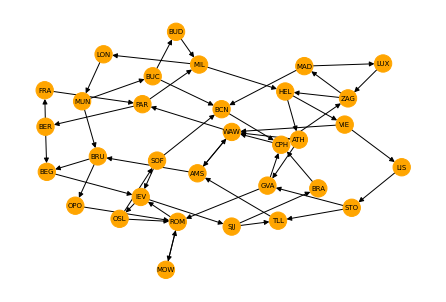

In [137]:
G = graph_generator()
draw_graph(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

#### Gerar subgrafo minimal

O grafo é ligado!
Foram removidas 14 arestas.


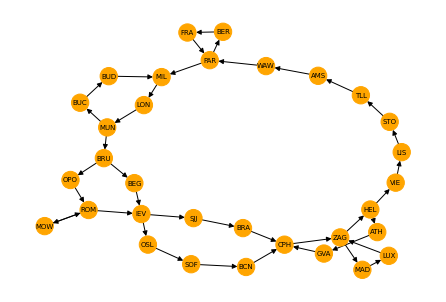

In [138]:
S = sub_graph_generator(G)
draw_graph(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')

#### Gerar digrafo - método 2

O grafo é ligado!


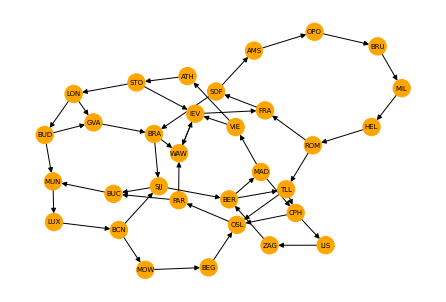

In [139]:
G = graph_generator_simple()
draw_graph(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

#### Gerar subgrafo minimal

O grafo é ligado!
Foram removidas 15 arestas.


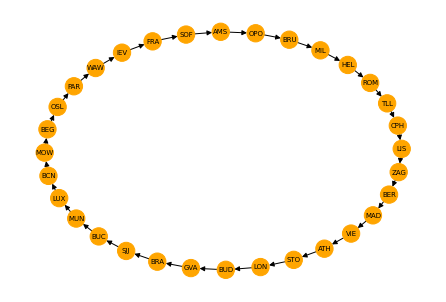

In [140]:
S = sub_graph_generator(G)
draw_graph(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')

### Exemplo 2

In [8]:
NUM_NODES = 10 
MAX_OUT_DEGREE = 3 

#### Gerar digrafo - método 1

O grafo é ligado!


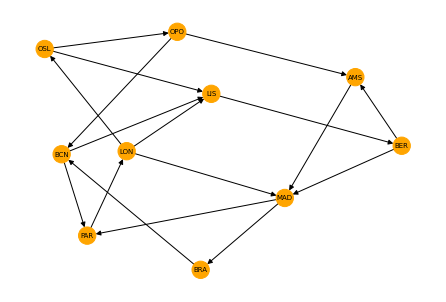

In [153]:
G = graph_generator()
draw_graph(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

#### Gerar subgrafo minimal

O grafo é ligado!
Foram removidas 6 arestas.


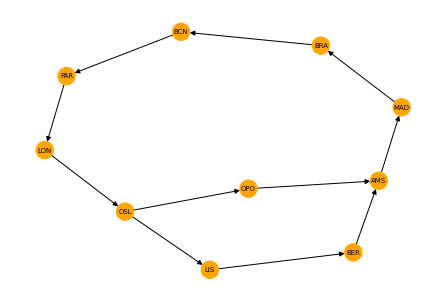

In [154]:
S = sub_graph_generator(G)
draw_graph(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')

#### Gerar digrafo - método 2

O grafo é ligado!


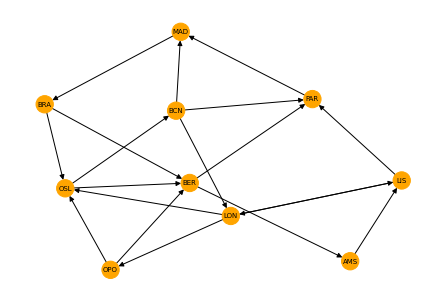

In [144]:
G = graph_generator_simple()
draw_graph(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

#### Gerar subgrafo minimal

O grafo é ligado!
Foram removidas 9 arestas.


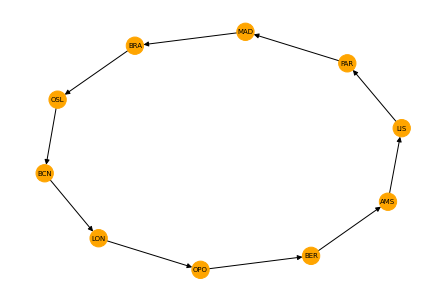

In [145]:
S = sub_graph_generator(G)
draw_graph(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')

### Exemplo 3

In [9]:
NUM_NODES = 15 
MAX_OUT_DEGREE = 3 

#### Gerar digrafo - método 1

O grafo é ligado!


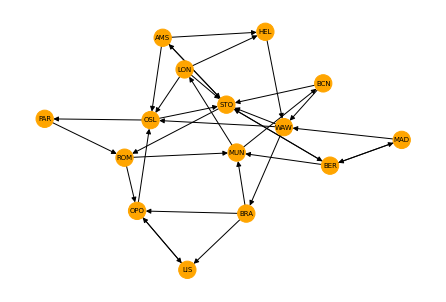

In [147]:
G = graph_generator()
draw_graph(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

#### Gerar subgrafo minimal

O grafo é ligado!
Foram removidas 16 arestas.


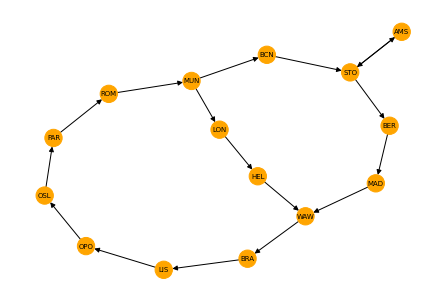

In [148]:
S = sub_graph_generator(G)
draw_graph(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')

#### Gerar digrafo - método 2

O grafo é ligado!


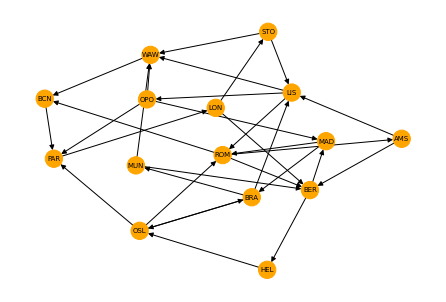

In [149]:
G = graph_generator_simple()
draw_graph(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

#### Gerar subgrafo minimal

O grafo é ligado!
Foram removidas 16 arestas.


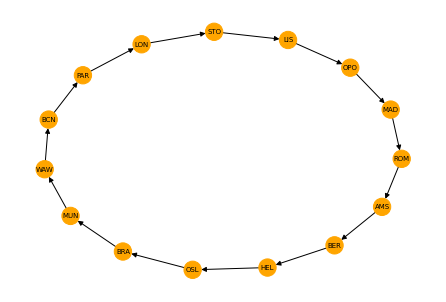

In [150]:
S = sub_graph_generator(G)
draw_graph(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')